# Text classification

This notebook analyses a collection of text documents (newsgroups posts) on twenty different topics. The steps we will cover are
1. Load the file contents and the categories
2. Extract feature vectors suitable for machine learning
3. Train a linear model to perform classification

Further work: Use a grid search strategy to find a good configuration of both the feature extraction components and the classifier

Loading the 20 newsgroups dataset

In [1]:
from sklearn.datasets import fetch_20newsgroups

In [2]:
twenty_train_all = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)

Check the target names

In [3]:
twenty_train_all.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In order to get faster execution times for this first example, we will work on a partial dataset with only 4 categories out of the 20 available in the dataset.

In [4]:
categories = ['comp.graphics', 'sci.space', 'sci.med','sci.crypt']

In [5]:
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, categories=categories)

Check the categories

In [6]:
twenty_train.target_names

['comp.graphics', 'sci.crypt', 'sci.med', 'sci.space']

Print the first lines of the first loaded file.

In [7]:
print("\n".join(twenty_train.data[0].split("\n")[:3]))

From: gtoal@news.ibmpcug.co.uk (Graham Toal)
Subject: Re: Secret algorithm [Re: Clipper Chip and crypto key-escrow]
Organization: /etc/organization


In [9]:
twenty_train

{'data': ["From: gtoal@news.ibmpcug.co.uk (Graham Toal)\nSubject: Re: Secret algorithm [Re: Clipper Chip and crypto key-escrow]\nOrganization: /etc/organization\nLines: 17\nNNTP-Posting-Host: dorothy.ibmpcug.co.uk\nKeywords: encryption, wiretap, clipper, key-escrow, Mykotronx\n\nIn article <strnlghtC5LGFI.JqA@netcom.com> strnlght@netcom.com (David Sternlight) writes:\n>\n>Though some may argue about the nose of the camel, it's worth noting that\n>the government proposal is limited to scrambled telephony. If it is only\n>used for that purpose, and does not extend to electronic mail or file\n>encryption, then it IS an improvement over the current mass-produced\n>standard civilian technology which, with a few exceptions, is limited to\n>easy-to-break inverters.\n\nTry reading between the lines David - there are *strong* hints in there\nthat they're angling for NREN next, and the only conceivable meaning of\napplying this particular technology to a computer network is that they\nintend it 

Supervised learning algorithms will require a category label for each document in the training set. In this case the category is the name of the newsgroup which also happens to be the name of the folder holding the individual documents.

In [10]:
twenty_train.target[:10]

array([1, 0, 2, 2, 0, 0, 0, 3, 3, 2], dtype=int64)

It is possible to get back the category names as follows. (Note: samples were shuffled randomly)

In [11]:
for t in twenty_train.target[:10]:
    print(twenty_train.target_names[t])

sci.crypt
comp.graphics
sci.med
sci.med
comp.graphics
comp.graphics
comp.graphics
sci.space
sci.space
sci.med


## Extracting features from text files

### Bag-of-Words

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape

(2366, 39867)

The index value of a word in the vocabulary is linked to its frequency in the whole training corpus.

In [13]:
count_vect.vocabulary_.get(u'algorithm')

6386

### TF-IDF vectorisation

Occurrence count is a good start but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.

To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies.

In the code below, fit_transofrm() method fits the estimator to the data and transforms the count-matrix to a tf-idf representation. 

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2366, 39867)

## Training a classifier

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

log_reg_clf = LogisticRegression().fit(X_train_tfidf, twenty_train.target)
nb_clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)

### Predict the outcome on a new document

In [16]:
docs_new = ['Andromeda galaxy is nearest to the solar system', 'OpenGL on the GPU is fast']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

log_reg_pred = log_reg_clf.predict(X_new_tfidf)
nb_pred = nb_clf.predict(X_new_tfidf)

print("Logistic Regression")
for doc, category in zip(docs_new, log_reg_pred):
    print('%r => %s' % (doc, twenty_train.target_names[category]))

print("Naive Bayes")
for doc, category in zip(docs_new, log_reg_pred):
    print('%r => %s' % (doc, twenty_train.target_names[category]))


Logistic Regression
'Andromeda galaxy is nearest to the solar system' => sci.space
'OpenGL on the GPU is fast' => comp.graphics
Naive Bayes
'Andromeda galaxy is nearest to the solar system' => sci.space
'OpenGL on the GPU is fast' => comp.graphics


### Building a pipeline

In order to make the vectorizer => text to vector transformer => classifier easier to work with, scikit-learn provides a Pipeline class that behaves like a compound classifier:

In [19]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

In [20]:
text_clf.fit(twenty_train.data, twenty_train.target)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())])

LogisticRegression model accuracy

In [21]:
import numpy as np
twenty_test = fetch_20newsgroups(subset='test',
    categories=categories, shuffle=True, random_state=42)
docs_test = twenty_test.data
predicted = text_clf.predict(docs_test)
np.mean(predicted == twenty_test.target)

0.9136507936507936

Check with a different model SGDClassifier to see if the accuracy increases

In [22]:
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

text_clf.fit(twenty_train.data, twenty_train.target)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

SGDClassifier model accuracy

In [23]:
predicted = text_clf.predict(docs_test)
np.mean(predicted == twenty_test.target)

0.9358730158730159

Classification report

In [24]:
from sklearn import metrics
print(metrics.classification_report(twenty_test.target, predicted,
    target_names=twenty_test.target_names))

               precision    recall  f1-score   support

comp.graphics       0.85      0.96      0.90       389
    sci.crypt       0.98      0.94      0.96       396
      sci.med       0.95      0.91      0.93       396
    sci.space       0.97      0.94      0.96       394

     accuracy                           0.94      1575
    macro avg       0.94      0.94      0.94      1575
 weighted avg       0.94      0.94      0.94      1575



Confusion Matrix

In [25]:
cm = metrics.confusion_matrix(twenty_test.target, predicted)
cm

array([[373,   5,   5,   6],
       [ 18, 371,   4,   3],
       [ 33,   2, 360,   1],
       [ 15,   0,   9, 370]], dtype=int64)

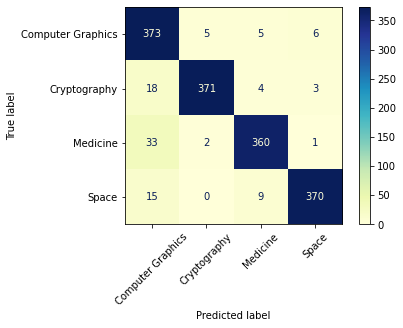

In [26]:
labels = ['Computer Graphics','Cryptography','Medicine','Space']
#twenty_test.target_names
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot(cmap='YlGnBu',xticks_rotation = 45)